#### Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Importing all the important libraries 

In [2]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

#### This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path("path_to_train_directory")
#data_dir_test = pathlib.Path('path_to_test_directory')

data_dir_train = pathlib.Path("/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/")
data_dir_test = pathlib.Path("/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing
 
#### Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

#### Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

####  Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


####  Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

2024-01-14 11:05:43.114991: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13935930 exceeds 10% of free system memory.
2024-01-14 11:05:43.242893: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18048000 exceeds 10% of free system memory.
2024-01-14 11:05:43.437579: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2024-01-14 11:05:43.451606: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2024-01-14 11:05:43.557499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.


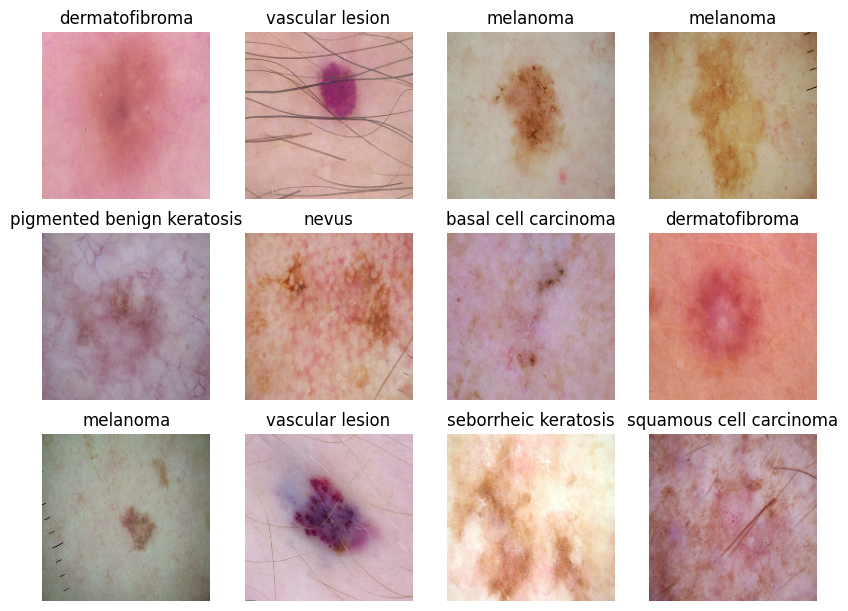

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

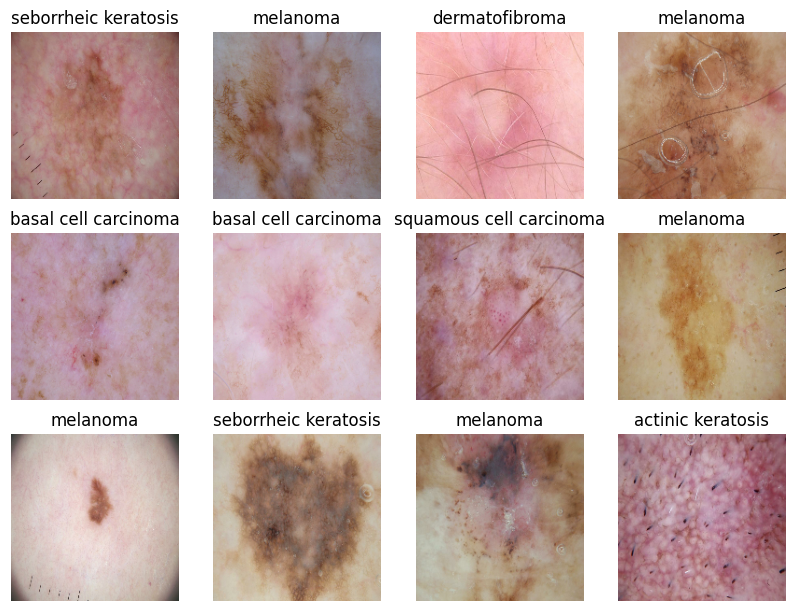

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####  Create the model 

##### Create a CNN model, which can accurately detect 9 classes present in the dataset.Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model
##### Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-01-14 11:06:27.664371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 11 of 1000
2024-01-14 11:06:47.312676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 39 of 1000
2024-01-14 11:07:07.626929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 69 of 1000
2024-01-14 11:07:27.467410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 98 of 1000
2024-01-14 11:07:38.407804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 109 of 1000


#### this output shows the completion of the 20th epoch, the progress through batches, the time taken for each batch, and the training and validation metrics for the current epoch. It provides insights into the performance and training dynamics of the CNN.

#### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### This discrepancy between training and validation accuracy suggests that the model might be overfitting to the training data

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [39]:
## Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [40]:
## code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## code goes here, note: train model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

###### After 20 epochs, the model achieved an accuracy of 88.06% on the training dataset, but its performance on the validation dataset was lower, with an accuracy of 51.90%. This discrepancy between training and validation accuracy suggests that the model might be overfitting to the training data

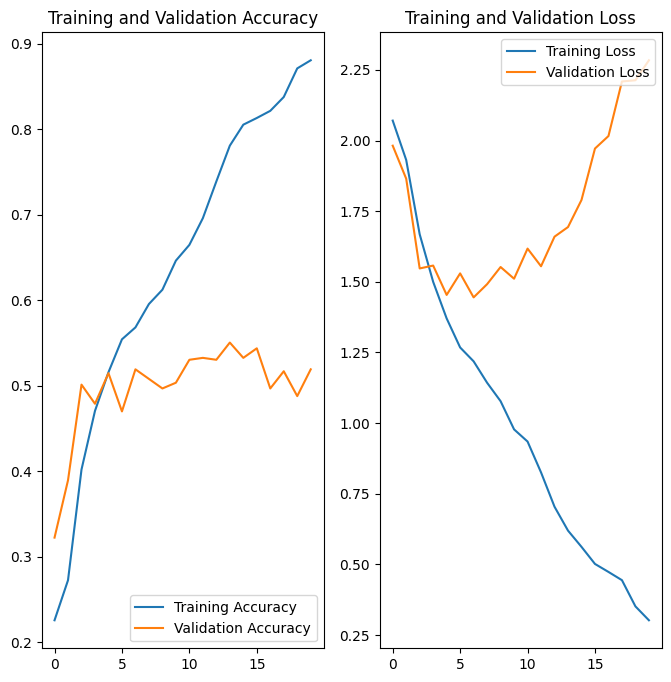

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### In the Training and  Validation Accuracy subplot, can see how the accuracy evolves over training epochs for both the training and validation datasets.
#### In the Training and Validation loss subplot, also can observe how the loss changes over epochs for both the training and validation datasets.
#### These plots help in visualizing the training process and diagnosing potential issues like overfitting or underfitting. If the training accuracy is improving while the validation accuracy is not, it might indicate overfitting. If both training and validation accuracy are low, it might suggest underfitting.

In [43]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [44]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,nevus
1,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,nevus
2,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,nevus
3,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,nevus
4,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,nevus
...,...,...
2234,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,pigmented benign keratosis
2235,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,pigmented benign keratosis
2236,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,pigmented benign keratosis
2237,/home/jahid/CNN_assignment/Skin_cancer_ISIC_Th...,pigmented benign keratosis


Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=7, n=181 (8.084%)
Class=2, n=95 (4.243%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)


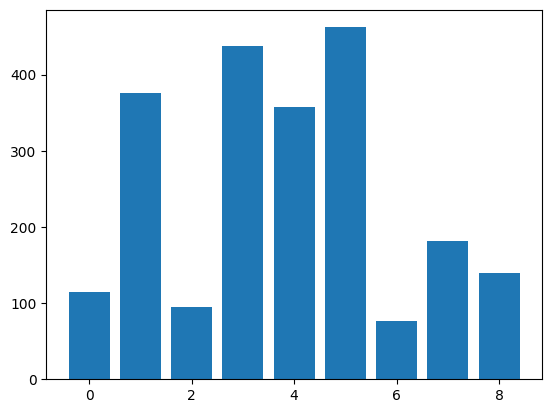

In [45]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [47]:
path_to_training_dataset="/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FD874F550>: 100%


Initialised with 376 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FD8453B50>: 100%


Initialised with 95 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FFC552B00>: 100%


Initialised with 438 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1FD84F43D0>: 100


Initialised with 357 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F1FD8481360>: 10


Initialised with 462 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FD8306200>: 100%


Initialised with 77 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1FD84805B0>: 100


Initialised with 181 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FD84F6E60>: 100%


Initialised with 139 image(s) found.
Output directory set to /home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000492.jpg_8cadaa95-75e9-409a-aa94-5f1ec596205b.jpg',
 '/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000318.jpg_16c8943a-4831-43a5-9601-6ceb47fdc9a0.jpg',
 '/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000359.jpg_c6d13e6f-1250-464f-ade0-49f8a15b9877.jpg',
 '/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000442.jpg_769794e2-f41f-4740-a306-d27edcfa9e55.jpg',
 '/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output/nevus_original_ISIC_0000096.jpg_f59af46d-9122-4cb2-9776-cfdf4ccc953a.jpg',
 '/home/jahid/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imagin

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [64]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

print(type(new_df))


<class 'pandas.core.frame.DataFrame'>


In [57]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [19]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [21]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

####  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##After 30 epochs, the model achieved an accuracy of 94.06% on the training dataset with an accuracy of 71.90%. This discrepancy between training and validation accuracy suggests that the model might be overfitting to the training. 
